In [ ]:
# IMPORTANT: this example depends on the cuprates_transport package
# https://github.com/gaelgrissonnanche/cuprates_transport
from cuprates_transport.bandstructure import BandStructure
from cuprates_transport.conductivity import Conductivity

from time import time
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
# matplotlib settings
# reset defaults
mpl.rcdefaults()
# font
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['pdf.fonttype'] = 3
# plotting
mpl.rcParams['figure.figsize'] = (7.48, 4.0)
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 20

In [3]:
params_chambers = {
    "band_name": "PdCrO2",
    "a": 2.94,
    "b": 2.94,
    "c": 18.06,
    "energy_scale": -789,
    "band_params": {
        "mu": -0.22,
        "t": 1,
        "tp": -0.23,
        "tz": 0.03
    },
    "resolution": [
        30,
        30,
        30
    ],
    "k_max": [
        3.141592653589793,
        3.141592653589793,
        9.42477796076938
    ],
    "number_of_bz": 0.8660254037844386,
    "band_model": "mu + t*(2*cos(sqrt(3)/2*a*kx)*cos(1/2*b*ky) + cos(b*ky)) + tp*(2*cos(sqrt(3)/2*a*kx)*cos(3/2*b*ky) + cos(sqrt(3)*a*kx)) + tz*(cos(sqrt(3)*a*kx/3+c*kz/3) + cos(-sqrt(3)*a*kx/6+a*ky/2+c*kz/3) + cos(-sqrt(3)*a*kx/6-a*ky/2+c*kz/3))",
    "Bamp": 41.5,
    "T": 0,
    "N_time": 10000,
    "scattering_models": [
        "isotropic",
    ],
    "scattering_params": {
        "gamma_0": 1.0
    },
    "atol": 1.5e-08,
    "rtol": 1.5e-08,
    "march_square": False
}

In [4]:
params_fem = params_chambers.copy()
params_fem['dispersion'] = params_chambers['band_model']
params_fem['resolution'] = 41
params_fem['domain_size'] = [1.0, 1.0, 3.0]
params_fem['periodic'] = True
params_fem['bz_ratio'] = params_chambers['number_of_bz']
params_fem = elecboltz.easy_params(params_fem)

In [5]:
field_mag = 41.5
field_phi = np.array([0, 30, 45, 60])
field_theta = np.linspace(60, 210, 300)

In [6]:
rho_chambers_zz = np.empty((len(field_phi), len(field_theta)))
params_chambers['Bamp'] = field_mag
time_start = time()

band_chambers = BandStructure(**params_chambers)
band_chambers.runBandStructure()
for i, phi in enumerate(field_phi):
    params_chambers['Bphi'] = phi
    for j, theta in enumerate(field_theta):
        params_chambers['Btheta'] = theta
        cond_chambers = Conductivity(band_chambers, **params_chambers)
        cond_chambers.runTransport()
        rho_chambers = np.linalg.inv(cond_chambers.sigma)
        rho_chambers_zz[i, j] = rho_chambers[2, 2]

params_chambers['Btheta'] = 0
cond_chambers = Conductivity(band_chambers, **params_chambers)
cond_chambers.runTransport()
rho_chambers = np.linalg.inv(cond_chambers.sigma)
rho_chambers_zz_0 = rho_chambers[2, 2]

time_end = time()
time_chambers = time_end - time_start

In [7]:
rho_fem_zz = np.empty((len(field_phi), len(field_theta)))
time_start = time()

band_fem = elecboltz.BandStructure(**params_fem)
band_fem.discretize()
cond_fem = elecboltz.Conductivity(band_fem, **params_fem)
cond_fem.Bamp = field_mag
for i, phi in enumerate(field_phi):
    cond_fem.Bphi = phi
    for j, theta in enumerate(field_theta):
        cond_fem.Btheta = theta
        cond_fem.calculate()
        rho_fem = np.linalg.inv(cond_fem.sigma)
        rho_fem_zz[i, j] = rho_fem[2, 2]

cond_fem.Bphi = 0
cond_fem.Btheta = 0
cond_fem.calculate()
rho_fem = np.linalg.inv(cond_fem.sigma)
rho_fem_zz_0 = rho_fem[2, 2]

time_end = time()
time_fem = time_end - time_start

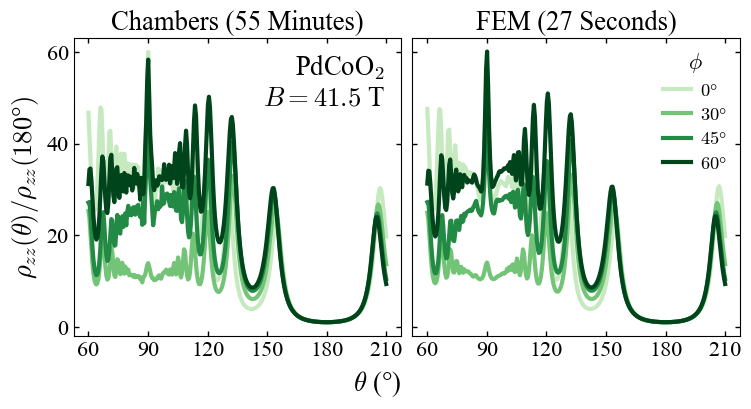

In [13]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
for i, phi in enumerate(field_phi):
    axs[0].plot(field_theta, (rho_chambers_zz[i, :] / rho_chambers_zz_0),
                label=f"${phi}$°",
                color=mpl.cm.Greens((i+1) / len(field_phi)))
    axs[1].plot(field_theta, (rho_fem_zz[i, :] / rho_fem_zz_0),
                label=f"${phi}$°",
                color=mpl.cm.Greens((i+1) / len(field_phi)))
axs[0].text(0.95, 0.95, f"PdCoO$_2$\n$B={field_mag}$ T", fontsize='large',
            ha='right', va='top', transform=axs[0].transAxes)
axs[0].set_title(f"Chambers ({int(time_chambers//60)} Minutes)")
axs[1].set_title(f"FEM ({int(round(time_fem%60))} Seconds)")
fig.supxlabel(r"$\theta$ (°)", va='bottom')
axs[0].set_xticks([60, 90, 120, 150, 180, 210])
axs[1].set_xticks([60, 90, 120, 150, 180, 210])
axs[0].set_ylabel(r"$\rho_{zz}(\theta)/\rho_{zz}(180$°$)$",
                  fontsize='large')
axs[1].legend(frameon=False, handlelength=1.5, handletextpad=0.5,
              borderaxespad=0.3, labelspacing=0.4, title=r"$\phi$")
plt.tight_layout(pad=0.3)
plt.savefig("PdCoO2/ADMR_PdCoO2_FEM_vs_Chambers.pdf", bbox_inches='tight')
plt.show()